## Предсказание стоимости жилья

В проекте вам нужно обучить модель линейной регрессии на данных о жилье в Калифорнии в 1990 году. На основе данных нужно предсказать медианную стоимость дома в жилом массиве. Обучите модель и сделайте предсказания на тестовой выборке. Для оценки качества модели используйте метрики RMSE, MAE и R2.

# Подготовка данных

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import isnan, when, count, col, coalesce 

from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.mllib.evaluation import RegressionMetrics

from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.regression import GBTRegressor

pyspark_version = pyspark.__version__
if int(pyspark_version[:1]) == 3:
    from pyspark.ml.feature import OneHotEncoder    
elif int(pyspark_version[:1]) == 2:
    from pyspark.ml.feature import OneHotEncodeEstimator
        
RANDOM_SEED = 2022

spark = SparkSession.builder \
                    .master("local") \
                    .appName("California housing - Linear regression") \
                    .getOrCreate()

In [2]:
df = spark.read.option('header', 'true').csv('/datasets/housing.csv', inferSchema = True)

    Тут вопрос: total_bedrooms имеют практически линейную зависимость от households,
    если смотреть на распределение их соотношения total_bedrooms/households, мы получим значение около 0,9, следовательно корректно заполнить пропуски можно через households*0,9, но я не нашел как это сделать, только стратегии зааполнения

In [3]:
#КОД РЕВЬЮЕРА
df = df.withColumn("help_households",col("households")* 0.9)
df = df.withColumn("total_bedrooms",coalesce(df["total_bedrooms"], df["help_households"]))
df=df.drop('help_households')

In [4]:
#сгенерируем дополнительные признаки на основе имеющихся
df = df.withColumn('rooms_per_household',
                                   F.col('total_rooms')/F.col('households')).withColumn('bedroom_index', 
                                                                                        F.col('total_bedrooms')/F.col('total_rooms')).withColumn('population_in_household',
                                                                                                                                                 F.col('population')/F.col('households'))

In [8]:
df.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
longitude,20640,-119.56970445736148,2.003531723502584,-124.35,-114.31
latitude,20640,35.6318614341087,2.135952397457101,32.54,41.95
housing_median_age,20640,28.639486434108527,12.58555761211163,1.0,52.0
total_rooms,20640,2635.7630813953488,2181.6152515827944,2.0,39320.0
total_bedrooms,20640,537.0797722868215,420.7749347739759,1.0,6445.0
population,20640,1425.4767441860465,1132.46212176534,3.0,35682.0
households,20640,499.5396802325581,382.3297528316098,1.0,6082.0
median_income,20640,3.8706710029070246,1.899821717945263,0.4999,15.0001
median_house_value,20640,206855.81690891474,115395.61587441359,14999.0,500001.0


In [9]:
#df.filter(col("total_bedrooms").isNotNull())

Перенес PrintSchema ниже, после добавления финальной колонки

In [10]:
#df.cache()
#df.printSchema()

In [11]:
#df = df.withColumn('bedroom_index', F.col('total_bedrooms')/F.col('total_rooms'))

In [12]:
df.printSchema()

root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)
 |-- ocean_proximity: string (nullable = true)
 |-- rooms_per_household: double (nullable = true)
 |-- bedroom_index: double (nullable = true)
 |-- population_in_household: double (nullable = true)



In [13]:
nan_table = \
df.select(
    [F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c) for c in df.columns]
    ).toPandas().T.rename(columns={0:'NA'})
nan_table['NA_percents'] = nan_table['NA'] / df.count() * 100
display(nan_table)

,NA,NA_percents
longitude,0,0.0
latitude,0,0.0
housing_median_age,0,0.0
total_rooms,0,0.0
total_bedrooms,0,0.0
population,0,0.0
households,0,0.0
median_income,0,0.0
median_house_value,0,0.0
ocean_proximity,0,0.0


In [14]:
#df = df.dropna(how = 'any', subset = 'total_bedrooms')

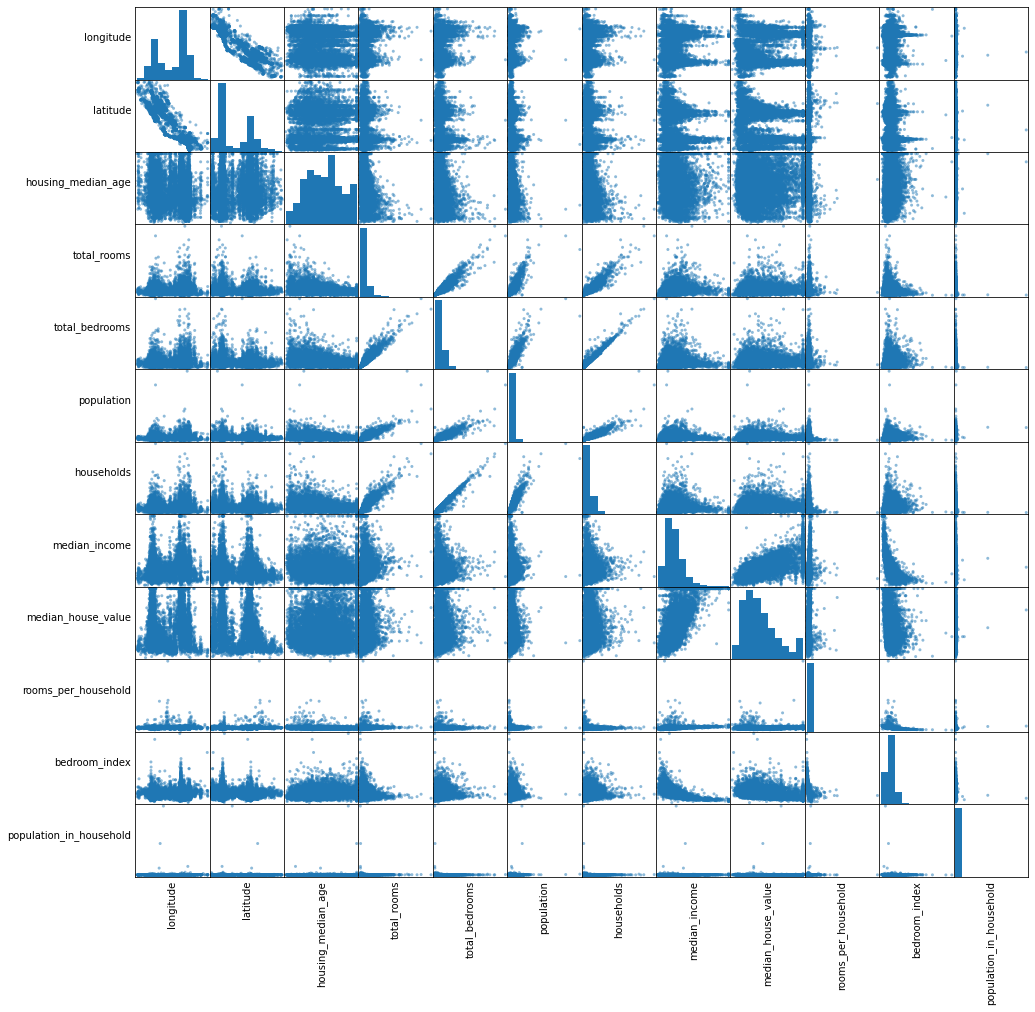

In [15]:
numeric_features = [t[0] for t in df.dtypes if t[1] == 'int' or t[1] == 'double']
sampled_data = df.select(numeric_features).sample(False, 0.5).toPandas()
axs = pd.plotting.scatter_matrix(sampled_data, figsize=(16, 16))
n = len(sampled_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

In [16]:
import six
for i in df.columns:
    if not( isinstance(df.select(i).take(1)[0][0], six.string_types)):
        print( "Correlation to median_house_value for ", i, df.stat.corr('median_house_value',i))

Correlation to median_house_value for  longitude -0.045966615117981745
Correlation to median_house_value for  latitude -0.14416027687465752
Correlation to median_house_value for  housing_median_age 0.10562341249321067
Correlation to median_house_value for  total_rooms 0.13415311380656275
Correlation to median_house_value for  total_bedrooms 0.05058611679076617
Correlation to median_house_value for  population -0.024649678888894876
Correlation to median_house_value for  households 0.06584265057005637
Correlation to median_house_value for  median_income 0.6880752079585578
Correlation to median_house_value for  median_house_value 1.0
Correlation to median_house_value for  rooms_per_household 0.15194828974146016
Correlation to median_house_value for  bedroom_index -0.25523888604162576
Correlation to median_house_value for  population_in_household -0.023737412956134192


из графика и корреляций можно сказать, что самое большое влияние на медианную стоимость жилья имеет доход 

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

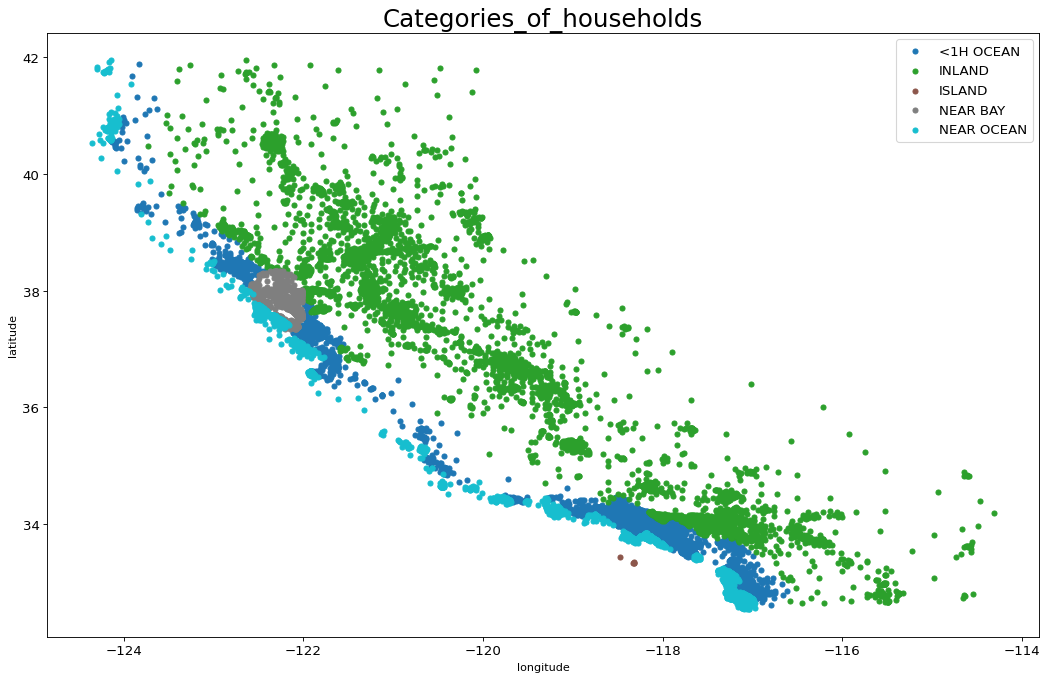

In [17]:
data = df.toPandas()[['ocean_proximity', 'longitude', 'latitude']]
categories = np.unique(data['ocean_proximity'])
colors = [plt.cm.tab10(i/float(len(categories)-1)) for i in range(len(categories))]

plt.figure(figsize=(16, 10), dpi= 80, facecolor='w', edgecolor='k')

for i, category in enumerate(categories):
    plt.scatter('longitude', 'latitude', 
                data=data.loc[data.ocean_proximity==category, :], 
                s=20, c=colors[i], label=str(category))

# Decorations
plt.gca().set(xlabel='longitude', ylabel='latitude')

plt.xticks(fontsize=12); plt.yticks(fontsize=12)
plt.title("Categories_of_households", fontsize=22)
plt.legend(fontsize=12)    
plt.show()  

# Обучение моделей

In [18]:
numerical_assembler = VectorAssembler(inputCols=['longitude',
                                                 'latitude',
                                                 'housing_median_age',
                                                 'total_rooms',
                                                 'total_bedrooms',
                                                 'population',
                                                 'households',
                                                 'median_income',
                                                 'rooms_per_household',
                                                 'bedroom_index',
                                                 'population_in_household'],
                                      outputCol="numerical_features")
df = numerical_assembler.transform(df) 
standardScaler = StandardScaler(inputCol='numerical_features',
                                outputCol="numerical_features_scaled")

df = standardScaler.fit(df).transform(df) 

In [19]:
indexer = StringIndexer(inputCols=['ocean_proximity'], 
                        outputCols=['ocean_proximity_idx']) 
df = indexer.fit(df).transform(df)

encoder = OneHotEncoder(inputCols=['ocean_proximity_idx'],
                        outputCols=['ocean_proximity_ohe'])
df = encoder.fit(df).transform(df)

categorical_assembler =VectorAssembler(inputCols=['ocean_proximity_ohe'],
                                        outputCol="categorical_features")
df = categorical_assembler.transform(df)

In [20]:
#vectorAssembler = VectorAssembler(inputCols = ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income'], outputCol = 'features')
all_features_wc = ['categorical_features', 'numerical_features_scaled']
#all_features = ['numerical_features_scaled']
#создадим 2 ассемблера для формирования 2 датасетов, с категорийными данными и без
final_cat_assembler = VectorAssembler(inputCols=all_features_wc, 
                                  outputCol='features')
#final_assembler = VectorAssembler(inputCols=all_features, 
#                                  outputCol='features')
#создадим датасеты для обучения
fin_df = final_cat_assembler.transform(df)
fin_df = fin_df.select(['features', 'numerical_features_scaled', 'median_house_value'])
fin_df.show(3)
#fin_df = final_assembler.transform(df)
#fin_df = fin_df.select(['features', 'median_house_value'])
#fin_df.show(3)

+--------------------+-------------------------+------------------+
|            features|numerical_features_scaled|median_house_value|
+--------------------+-------------------------+------------------+
|[0.0,0.0,0.0,1.0,...|     [-61.007269596069...|          452600.0|
|[0.0,0.0,0.0,1.0,...|     [-61.002278409814...|          358500.0|
|[0.0,0.0,0.0,1.0,...|     [-61.012260782324...|          352100.0|
+--------------------+-------------------------+------------------+
only showing top 3 rows



 **Проверим работу модели без категорийных признаков**

In [21]:
train_df, test_df = fin_df.randomSplit([0.7, 0.3])

In [22]:
 #импорт перенесен
lr = LinearRegression(labelCol = 'median_house_value', featuresCol = 'numerical_features_scaled', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(train_df)
#print("Coefficients: " + str(lr_model.coefficients))
#print("Intercept: " + str(lr_model.intercept))

22/11/24 06:17:21 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
22/11/24 06:17:21 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


In [23]:
#Оценим метрики на train выборке
trainingSummary = lr_model.transform(train_df)
#исправлено
valuesAndPreds = trainingSummary.select(['prediction', 'median_house_value'])
valuesAndPreds = valuesAndPreds.rdd.map(tuple)
metrics = RegressionMetrics(valuesAndPreds)
# Squared Error
print("MSE = %s" % metrics.meanSquaredError)
print("RMSE = %s" % metrics.rootMeanSquaredError)
# Mean absolute error
print("MAE = %s" % metrics.meanAbsoluteError)
print("R2 = %s" % metrics.r2)


MSE = 4723547076.943062
RMSE = 68728.06615163169
MAE = 49688.81044385098
R2 = 0.6460771313936298


In [24]:
test_result = lr_model.evaluate(test_df)
print("Root Mean Squared Error (RMSE) on test data = %g" % test_result.rootMeanSquaredError)

Root Mean Squared Error (RMSE) on test data = 69243.9


In [26]:
lr_predictionsA = lr_model.transform(test_df)
valuesAndPreds = lr_predictionsA.select(['prediction', 'median_house_value'])
valuesAndPreds = valuesAndPreds.rdd.map(tuple)
metrics = RegressionMetrics(valuesAndPreds)
# Squared Error
print("MSE = %s" % metrics.meanSquaredError)
print("RMSE = %s" % metrics.rootMeanSquaredError)
# Mean absolute error
print("MAE = %s" % metrics.meanAbsoluteError)
print("R2 = %s" % metrics.r2)

MSE = 4794713382.008002
RMSE = 69243.86891276369
MAE = 50189.22985295125
R2 = 0.6379491742198378


**УЧИМ С КАТЕГОРИЙНЫМИ ДАННЫМИ**

In [27]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(labelCol = 'median_house_value', featuresCol = 'features', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(train_df)
print("Coefficients: " + str(lr_model.coefficients))
#print("Intercept: " + str(lr_model.intercept))

Coefficients: [18193.628187003265,-34648.59530051533,29903.942402552162,16718.590463049037,-16262.05058443652,-13515.582928772783,14996.372307540303,9553.797788387135,13737.521481241198,-30843.019760009134,13869.608083984322,84146.18374932303,2011.5956465313272,20152.29958872432,-948.904844707964]


In [28]:
#Оценим метрики на train выборке
ctrainingSummary = lr_model.transform(train_df)
valuesAndPreds = trainingSummary.select(['prediction', 'median_house_value'])
valuesAndPreds = valuesAndPreds.rdd.map(tuple)
metrics = RegressionMetrics(valuesAndPreds)

print("MSE = %s" % metrics.meanSquaredError)
print("RMSE = %s" % metrics.rootMeanSquaredError)

print("MAE = %s" % metrics.meanAbsoluteError)
print("R2 = %s" % metrics.r2)

MSE = 4723547076.943062
RMSE = 68728.06615163169
MAE = 49688.81044385098
R2 = 0.6460771313936298


In [29]:
#оценим данные на test
lr_predictionsB = lr_model.transform(test_df)
valuesAndPreds = lr_predictionsB.select(['prediction', 'median_house_value'])
valuesAndPreds = valuesAndPreds.rdd.map(tuple)
metrics = RegressionMetrics(valuesAndPreds)
# Squared Error
print("MSE = %s" % metrics.meanSquaredError)
print("RMSE = %s" % metrics.rootMeanSquaredError)
# Mean absolute error
print("MAE = %s" % metrics.meanAbsoluteError)
print("R2 = %s" % metrics.r2)

MSE = 4799268528.29764
RMSE = 69276.75315932206
MAE = 49603.35656813151
R2 = 0.6376052132060468


In [47]:
!pip install ggplot

     |████████████████████████████████| 2.2 MB 1.3 MB/s eta 0:00:01


# Анализ результатов

 **Мы получили следующие данные:**
        для обучения без категорийных столбцов: 
        
                                                RMSE = 70287.4717200304        
                                                MAE = 50059.857504163585                                                
                                                R2 = 0.6355508226476254
                                                
        для обучения с категорийными данными: 
                                              RMSE = 69981.1441946323
                                              MAE = 49716.57631566875
                                              R2 = 0.6387205920212413
                                              
Можем сделать вывод, что категорийные данные только вредят при обучении.
Если мы посмотрим на график распределения географических зон в зависимости от координат, мы видим, что нет четкого разграничения и данные часто пересекаются в областях, например зона near bay с остальными.
Возможно если бы мы получили адрес из координат было бы эффективнее зонировать по районам или городам залива.

Смог получить RMSE = 58973.00628153204 MAE = 41028.26718754351 R2 = 0.672588448134682 на gbtregressor, пока это лучший результат :)





## Бонус :)

In [ ]:
from pyspark.ml.regression import DecisionTreeRegressor
dt = DecisionTreeRegressor(featuresCol ='features', labelCol = 'median_house_value')
dt_model = dt.fit(train_df)
dt_predictions = dt_model.transform(test_df)
valuesAndPreds = dt_predictions.select(['prediction', 'median_house_value'])
valuesAndPreds = valuesAndPreds.rdd.map(tuple)
metrics = RegressionMetrics(valuesAndPreds)

print("MSE = %s" % metrics.meanSquaredError)
print("RMSE = %s" % metrics.rootMeanSquaredError)
print("MAE = %s" % metrics.meanAbsoluteError)
print("R2 = %s" % metrics.r2)

In [ ]:
dt_model.featureImportances

In [ ]:
df.take(1)

In [ ]:
from pyspark.ml.regression import GBTRegressor
gbt = GBTRegressor(labelCol = 'median_house_value', featuresCol = 'features', maxIter=10)
gbt_model = gbt.fit(train_df)
gbt_predictions = gbt_model.transform(test_df)
gbt_predictions.select('prediction', 'median_house_value', 'features').show(5)

In [ ]:
valuesAndPreds = gbt_predictions.select(['prediction', 'median_house_value'])
valuesAndPreds = valuesAndPreds.rdd.map(tuple)
metrics = RegressionMetrics(valuesAndPreds)

print("MSE = %s" % metrics.meanSquaredError)
print("RMSE = %s" % metrics.rootMeanSquaredError)
print("MAE = %s" % metrics.meanAbsoluteError)
print("R2 = %s" % metrics.r2)